# Tracking a moving stystem
## Outlier mean

We consider a state-space model of the form
$$
\begin{aligned}
    p(z_t \vert z_{t-1}) &= {\cal N}(z_t \vert F z_{t-1}, Q_t)\\
    p(y_t \vert z_t) &= \text{St}(y_t \vert  H_t z_t, R_t, \nu)
\end{aligned}
$$

In [1]:
import jax
import datagen
import pandas as pd
import numpy as np
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt


from functools import partial
from rebayes_mini import callbacks
from bayes_opt import BayesianOptimization
from rebayes_mini.methods import student_t_filter as stf
from rebayes_mini.methods import gauss_filter as kf
from rebayes_mini.methods import robust_filter as rkf
from rebayes_mini.methods import generalised_bayes_filter as gbf

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

plt.rcParams["font.size"] = 18
cmap = {
    "KF-IW": "crimson",
    "WLF-IMQ": "dodgerblue",
    "KF": "lightseagreen",
    "WLF-MD": "gold",
    "KF-B": "darkorange",
}

In [3]:
key = jax.random.PRNGKey(314)

## Multiple samples

In [4]:
delta = 0.1
dynamics_covariance = 0.1
obs_covariance = 10.0

In [5]:
name_dgen = "covariance"

match name_dgen:
    case "covariance":
        dgen = datagen.GaussStMovingObject2D(
            delta, dynamics_covariance, obs_covariance,
            dof_observed=2.1
        )
    case "mean":
        dgen = datagen.GaussMeanOutlierMovingObject2D(
            delta, dynamics_covariance, obs_covariance,
            outlier_proba=0.05,
            outlier_scale=2.0,
        )
    case _:
        raise ValueError(f"Dgen {name_dgen} not valid")

In [6]:
initial_mean = initial_mean = jnp.array([0.0, 0.0, 1.0, 1.0])

n_steps = 1000
n_samples = 500



colors = plt.cm.tab10(jnp.arange(n_samples))
colors = plt.cm.viridis(jnp.linspace(0, 1, n_samples))
keys = jax.random.split(key, n_samples)
datasets = jax.vmap(dgen.sample, in_axes=(0, None, None))(keys, initial_mean, n_steps)

yv = datasets["observed"]
state = datasets["latent"]

CPU times: user 6.88 s, sys: 1.24 s, total: 8.12 s
Wall time: 4.93 s


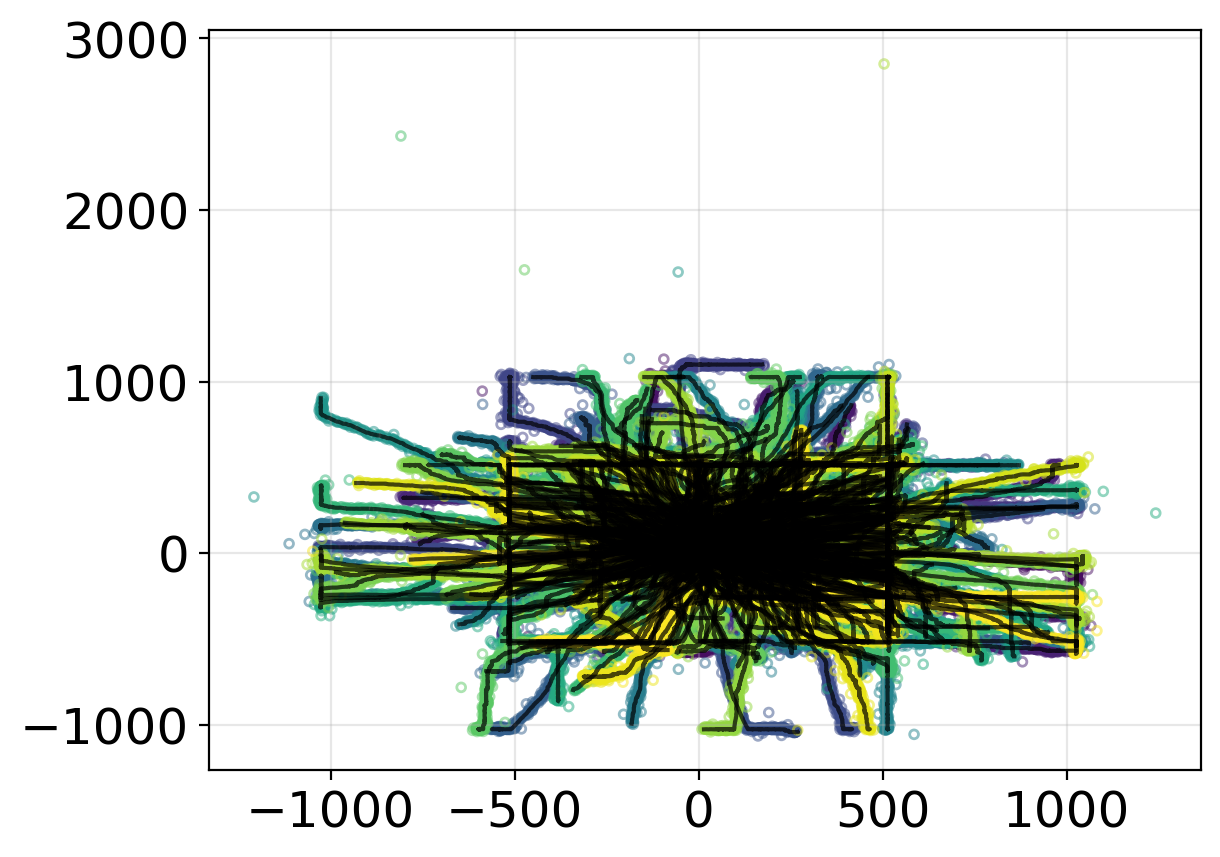

In [7]:
%%time
for i, color in enumerate(colors):
    dataset = jax.tree_map(lambda x: np.array(x[i]), datasets)
    plt.plot(*dataset["latent"][:, :2].T, c="black", alpha=0.7)
    plt.scatter(*dataset["observed"].T, edgecolor=color, color="none", s=10, alpha=0.5)
    
plt.grid(alpha=0.3)

In [8]:
def latent_fn(z):
    return dgen.transition_matrix @ z

def measurement_fn(z, _):
    return dgen.projection_matrix @ z

## Kalman Filter

In [9]:
@partial(jax.vmap, in_axes=(0, 0))
def vmap_filter_kf(measurements, state):
    nsteps = len(measurements)
    agent_imq = rkf.ExtendedKalmanFilterIMQ(
        latent_fn, measurement_fn,
        dynamics_covariance=dgen.dynamics_covariance,
        observation_covariance=dgen.observation_covariance,
        soft_threshold=1e8,
    )
    
    init_bel = agent_imq.init_bel(initial_mean, cov=1.0)
    filterfn = partial(agent_imq.scan, callback_fn=callbacks.get_updated_mean)
    _, hist = filterfn(init_bel, measurements, jnp.ones(n_steps))

    err = jnp.sqrt(jnp.power(hist - state, 2).sum(axis=0))
    return err, hist

In [10]:
%%time
_, hist_bel_kf_runs = vmap_filter_kf(yv, state)

diff_kf = jnp.power(hist_bel_kf_runs - state, 2)

jnp.sqrt(diff_kf.sum(axis=1)).mean(axis=0).block_until_ready()

CPU times: user 2.47 s, sys: 17.3 ms, total: 2.49 s
Wall time: 1.41 s


Array([100.48958, 103.32391, 112.89579, 110.57885], dtype=float32)

## KF-IW

In [12]:
@partial(jax.vmap, in_axes=(None, None, 0, 0))
def vmap_filter_kfiw(noise_scaling, n_inner, measurements, state):
    n_inner = n_inner.astype(int)
    agent_rkf = rkf.KalmanFilterInverseWishart(
        dgen.transition_matrix,
        dgen.dynamics_covariance,
        dgen.observation_covariance,
        n_inner=n_inner,
        noise_scaling=noise_scaling
    )
    
    
    init_bel = agent_rkf.init_bel(initial_mean, cov=1.0)
    filterfn = partial(agent_rkf.scan, callback_fn=callbacks.get_updated_mean)
    _, hist = filterfn(init_bel, measurements, dgen.projection_matrix)
    
    err = jnp.sqrt(jnp.power(hist - state, 2).sum(axis=0))
    return err, hist


@jax.jit
def bo_filter_kfiw(noise_scaling, n_inner):
    err, _ = vmap_filter_kfiw(noise_scaling, n_inner, yv[:1], state[:1])
    return -err.mean(axis=0).max()

In [13]:
%%time
bo = BayesianOptimization(
    bo_filter_kfiw,
    pbounds={
        "noise_scaling": (1e-6, 20),
        "n_inner":  (1, 10),
    },
    random_state=314,
    verbose=1
)
bo.maximize(init_points=20, n_iter=30)

|   iter    |  target   |  n_inner  | noise_... |
-------------------------------------------------
| 4         | -166.3    | 7.552     | 5.21      |
| 15        | -163.3    | 1.952     | 1.208     |
| 40        | -162.7    | 1.0       | 0.4274    |
CPU times: user 2min 23s, sys: 3min, total: 5min 24s
Wall time: 11.6 s


In [17]:
%%time
noise_scaling = bo.max["params"]["noise_scaling"]
n_inner = bo.max["params"]["n_inner"]
_, hist_bel_kfiw_runs = vmap_filter_kfiw(noise_scaling, n_inner, yv, state)
diff_kfiw = jnp.power(hist_bel_kfiw_runs - state, 2)

jnp.sqrt(diff_kfiw.sum(axis=1)).mean(axis=0).block_until_ready()

CPU times: user 3.51 s, sys: 74.7 ms, total: 3.58 s
Wall time: 1.52 s


Array([135.18883, 135.3995 , 117.60652, 112.41966], dtype=float32)

## Weighted (IMQ) Kalman Filter

In [18]:
@partial(jax.vmap, in_axes=(None, 0, 0))
def vmap_filter_wlfimq(soft_threshold, measurements, state):
    nsteps = len(measurements)
    agent = rkf.ExtendedKalmanFilterIMQ(
        latent_fn, measurement_fn,
        dynamics_covariance=dgen.dynamics_covariance,
        observation_covariance=dgen.observation_covariance,
        soft_threshold=soft_threshold,
    )
    
    init_bel = agent.init_bel(initial_mean, cov=1.0)
    filterfn = partial(agent.scan, callback_fn=callbacks.get_updated_mean)
    _, hist = filterfn(init_bel, measurements, jnp.ones(n_steps))

    err = jnp.sqrt(jnp.power(hist - state, 2).sum(axis=0))
    return err, hist


@jax.jit
def bo_filter_wlfimq(soft_threshold):
    err, _ = vmap_filter_wlfimq(soft_threshold, yv[:1], state[:1])
    return -err.mean(axis=0).max()

In [19]:
%%time
bo = BayesianOptimization(
    bo_filter_wlfimq,
    pbounds={
        "soft_threshold": (1e-6, 20)
    },
    random_state=314,
    verbose=1,
    allow_duplicate_points=True
)
bo.maximize(init_points=20, n_iter=30)

|   iter    |  target   | soft_t... |
-------------------------------------
| 2         | -166.4    | 11.77     |
| 3         | -164.6    | 5.301     |
| 8         | -164.6    | 5.21      |
| 16        | -164.5    | 5.564     |
| 29        | -163.1    | 4.328     |
| 39        | -162.5    | 3.991     |
CPU times: user 3min 12s, sys: 3min 40s, total: 6min 52s
Wall time: 6.9 s


In [20]:
%%time
soft_threshold = bo.max["params"]["soft_threshold"]
_, hist_bel_wlfimq_runs = vmap_filter_wlfimq(soft_threshold, yv, state)

diff_wlfimq = jnp.power(hist_bel_wlfimq_runs - state, 2)

jnp.sqrt(diff_wlfimq.sum(axis=1)).mean(axis=0).block_until_ready()

CPU times: user 2.03 s, sys: 58.2 ms, total: 2.08 s
Wall time: 1.38 s


Array([81.104034, 92.53954 , 72.348045, 72.02034 ], dtype=float32)

## Robust KF -- mahalanobis-based thresholding

In [23]:
@jax.jit
@partial(jax.vmap, in_axes=(None, 0, 0))
def vmap_filter_wlfmd(threshold, measurements, state):
    agent = rkf.ExtendedKalmanFilterMD(
        latent_fn, measurement_fn,
        dynamics_covariance=dgen.dynamics_covariance,
        observation_covariance=dgen.observation_covariance,
        threshold=threshold
    )
    
    init_bel = agent.init_bel(initial_mean, cov=1.0)
    
    _, hist = agent.scan(
        init_bel, measurements, jnp.ones(n_steps), callback_fn=callbacks.get_updated_mean
    )

    err = jnp.sqrt(jnp.power(hist - state, 2).sum(axis=0))
    return err, hist


@jax.jit
def bo_filter_wlfmd(threshold):
    err, _ = vmap_filter_wlfmd(threshold, yv[:1], state[:1])
    return -err.mean(axis=0).max()

In [24]:
%%time
bo = BayesianOptimization(
    bo_filter_wlfmd,
    pbounds={
        "threshold": (1e-6, 20)
    },
    random_state=314,
    verbose=1
)
bo.maximize(init_points=20, n_iter=30)

|   iter    |  target   | threshold |
-------------------------------------
| 2         | -167.8    | 11.77     |
| 3         | -166.9    | 5.301     |
| 8         | -166.7    | 5.21      |
| 12        | -166.7    | 5.231     |
| 16        | -166.7    | 5.564     |
CPU times: user 3min 18s, sys: 3min 45s, total: 7min 4s
Wall time: 7.72 s


In [25]:
%%time
threshold = bo.max["params"]["threshold"]
_, hist_bel_wlfmd_runs = vmap_filter_wlfmd(threshold, yv, state)
diff_wlfmd = jnp.power(hist_bel_wlfmd_runs - state, 2)

jnp.sqrt(diff_wlfmd.sum(axis=1)).mean(axis=0).block_until_ready()

CPU times: user 2.55 s, sys: 146 ms, total: 2.7 s
Wall time: 1.47 s


Array([165.86174, 107.72425,  96.72906,  96.74874], dtype=float32)

## Wang 2018

In [26]:
@jax.jit
@partial(jax.vmap, in_axes=(None, None, None, 0, 0))
def vmap_filter_kfb(alpha, beta, n_inner, measurements, state):
    """
    Outlier ekf
    """
    n_inner = n_inner.astype(int)
    agent = rkf.ExtendedKalmanFilterBernoulli(
        latent_fn, measurement_fn,
        dynamics_covariance=dgen.dynamics_covariance,
        observation_covariance=dgen.observation_covariance,
        alpha=alpha,
        beta=beta,
        tol_inlier=1e-7,
        n_inner=n_inner,
    )

    init_bel = agent.init_bel(initial_mean, cov=1.0)
    
    _, hist = agent.scan(
        init_bel, measurements, jnp.ones(n_steps), callback_fn=callbacks.get_updated_mean
    )

    err = jnp.sqrt(jnp.power(hist - state, 2).sum(axis=0))
    return err, hist


@jax.jit
def bo_filter_kfb(alpha, beta, n_inner):
    err, _ = vmap_filter_kfb(alpha, beta, n_inner, yv[:1], state[:1])
    err = -err.mean(axis=0).max()
    err = jax.lax.cond(jnp.isnan(err), lambda: -1e6, lambda: err)
    return err

In [27]:
%%time
bo = BayesianOptimization(
    bo_filter_kfb,
    pbounds={
        "alpha": (0.0, 5.0),
        "beta": (0.0, 5.0),
        "n_inner": (1, 10),
    },
    random_state=314,
    verbose=1
)
bo.maximize(init_points=20, n_iter=30)

|   iter    |  target   |   alpha   |   beta    |  n_inner  |
-------------------------------------------------------------
| 10        | -169.2    | 4.174     | 0.5288    | 1.544     |
CPU times: user 3min 16s, sys: 3min 39s, total: 6min 55s
Wall time: 16.1 s


In [29]:
%%time
alpha = bo.max["params"]["alpha"]
beta = bo.max["params"]["beta"]
n_inner = bo.max["params"]["n_inner"].astype(int)
_, hist_bel_kfb_runs = vmap_filter_kfb(alpha, beta, n_inner, yv, state)
diff_kfb = jnp.power(hist_bel_kfb_runs - state, 2)

jnp.sqrt(diff_kfb.sum(axis=1)).mean(axis=0).block_until_ready()

CPU times: user 6.17 ms, sys: 0 ns, total: 6.17 ms
Wall time: 694 ms


Array([100.48958, 103.32391, 112.89579, 110.57885], dtype=float32)

## Plot comparison

In [31]:
part_kf = pd.DataFrame(np.array(diff_kf.sum(axis=1))).melt()
part_kf["method"] = "KF"


part_oekf = pd.DataFrame(np.array(diff_kfb.sum(axis=1))).melt()
part_oekf["method"] = "KF-B"


part_rkf = pd.DataFrame(np.array(diff_kfiw.sum(axis=1))).melt()
part_rkf["method"] = "KF-IW"


part_imq = pd.DataFrame(np.array(diff_wlfimq.sum(axis=1))).melt()
part_imq["method"] = "WLF-IMQ"


part_mekf = pd.DataFrame(np.array(diff_wlfmd.sum(axis=1))).melt()
part_mekf["method"] = "WLF-MD"

In [32]:
diff_df = pd.concat([part_imq, part_rkf, part_kf, part_mekf, part_oekf], axis=0)
diff_df = diff_df.rename(
    {
        "variable": "state",
        "value": "error"
    },
    axis=1
)

diff_df["state"] = diff_df["state"].apply(lambda x: rf"$\theta_{x}$")

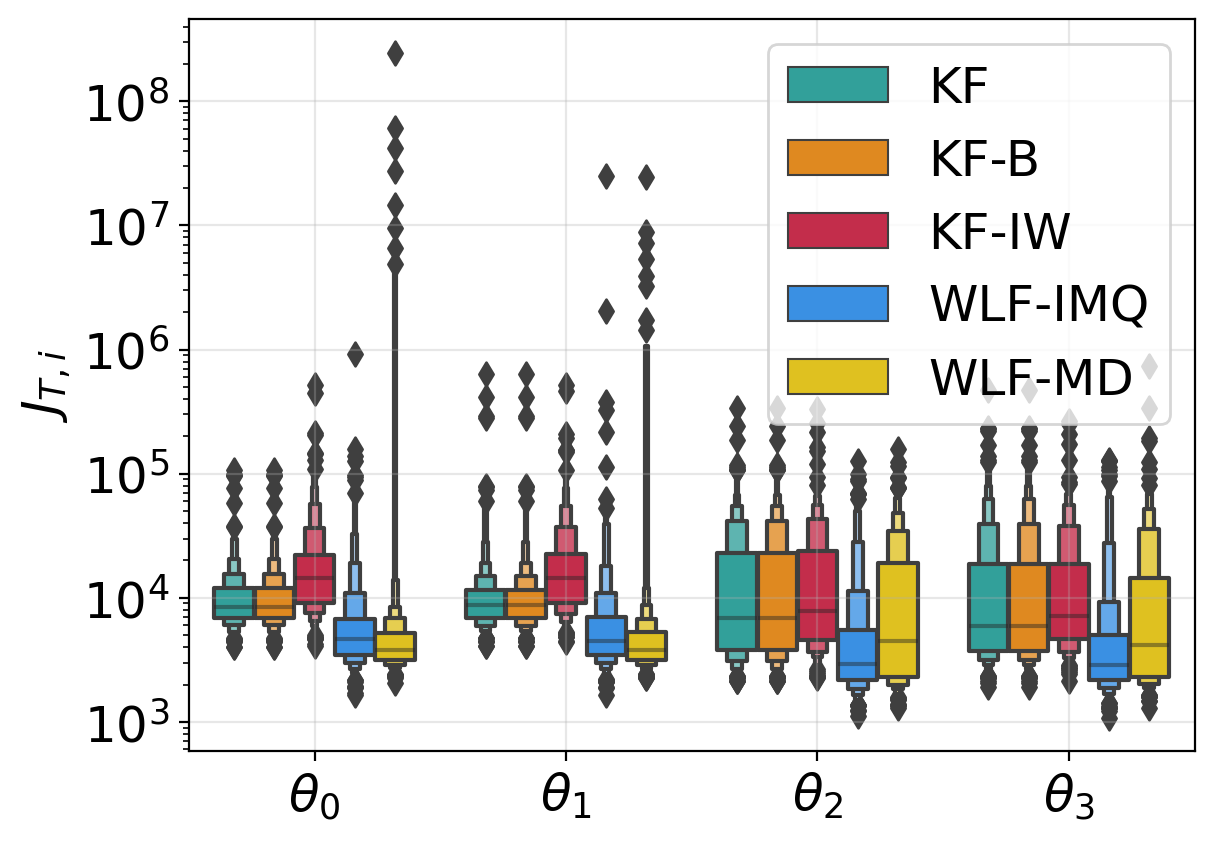

In [34]:
methods = sorted(diff_df.method.unique())
sns.boxenplot(
    y="error",
    x="state",
    hue="method",
    data=diff_df,
    palette=cmap,
    hue_order=methods,
)
plt.legend()
plt.xlabel("")
plt.ylabel("$J_{T,i}$")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.yscale("log")
# plt.savefig("./figures/2d-ssm-comparison-outlier-mean.png", dpi=300)

## Single model comparison

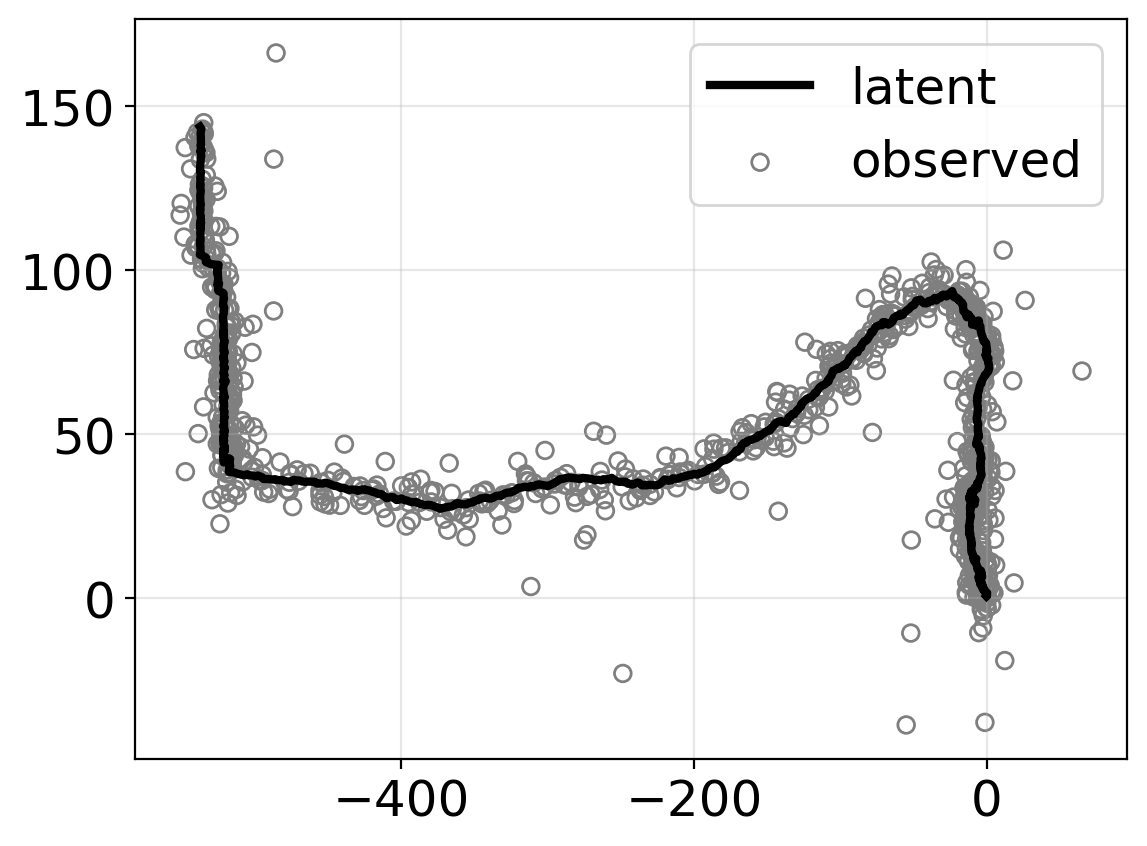

In [55]:
i = 15
i = 11
latent_i = datasets["latent"][i, :, :2].T
observed_i = yv[i]

plt.plot(*latent_i, c="black", label="latent", linewidth=3)
plt.scatter(*observed_i.T, c="none", edgecolor="tab:gray", label="observed")
plt.legend()
plt.grid(alpha=0.3)
# plt.savefig("./figures/2d-ssm-sample-outlier-mean.png", dpi=300)

In [56]:
latent_i = datasets["latent"][i, :, :2].T
hist_runs = {
    "KF": hist_bel_kf_runs[i, :, :2].T,
    "KF-B": hist_bel_kfb_runs[i, :, :2].T,
    "KF-IW": hist_bel_kfiw_runs[i, :, :2].T,
    "WLF-IMQ": hist_bel_wlfimq_runs[i, :, :2].T,
    "WLF-MD": hist_bel_wlfmd_runs[i, :, :2].T
}

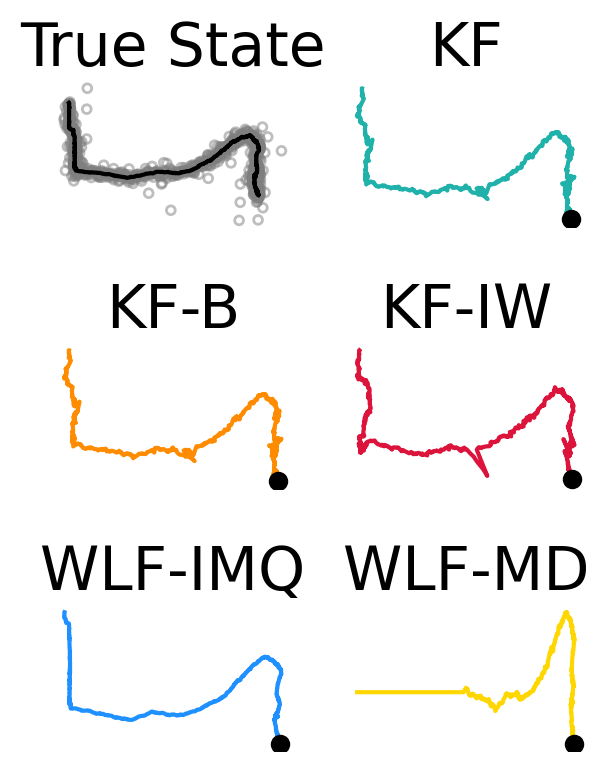

In [58]:
fig, axs = plt.subplots(3, 2, figsize=(6.4 * 0.5, 4.2))

for ax, key in zip(axs.ravel()[1:], hist_runs):
    state_est = hist_runs[key]
    ax.plot(*state_est, c=cmap[key])
    ax.set_title(key)
    ax.axis("off")
    ax.scatter(0,0, c="black", zorder=3)

axs[0, 0].scatter(*observed_i.T, c="none", edgecolor="tab:gray", label="observed", alpha=0.5, s=10)
axs[0, 0].plot(*latent_i, c="black", label="latent", linewidth=1.5)
axs[0, 0].axis("off")
axs[0, 0].set_title("True State")

plt.tight_layout()
# plt.savefig("./figures/2d-ssm-comparison-single-run-mean.png", dpi=300)